# Syn-VSFC

## Preparing Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install SentencePiece
!pip install transformers
!pip install pypi
!pip install transformers[torch]
!pip install accelerate -U

  Preparing metadata (setup.py) ... done
  Created wheel for pypi: filename=pypi-2.1-py3-none-any.whl size=1334 sha256=2e4afbc81c86665033f0baf3b6bccc8819da75b1057164ea340dfd33fad6e563
  Stored in directory: /root/.cache/pip/wheels/1c/29/dd/5bd57c07156e9a1ee0a45a9662fb5b5f400b17db94a8622d23
Successfully built pypi
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [4]:
data_train = pd.read_csv('/content/drive/MyDrive/IE403/Dataset/Syn-VSFC/synthetic_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/IE403/Dataset/Syn-VSFC/synthetic_test.csv')

In [5]:
data_train

,sentence,sentiment,topic
0,Đội ngũ bảo trì quá thưa thớt dẫn đến không đả...,negative,facility
1,The university's musical and artistic faciliti...,neutral,facility
2,Phương pháp giảng dạy phù hợp với các đối tượn...,neutral,curriculum
3,Chương trình học giúp tôi trở thành một chuyên...,positive,curriculum
4,Tôi nghĩ rằng chương trình đào tạo có thể có t...,neutral,curriculum
...,...,...,...
8139,Hệ thống an ninh trong trường rất tốt và đảm b...,neutral,facility
8140,Cô giáo đã giúp tôi hiểu rõ hơn về môn học này.,neutral,others
8141,Anh/chị đã trở thành một người bạn đồng hành v...,positive,others
8142,Chương trình học phù hợp với nhu cầu của các n...,neutral,curriculum


In [6]:
data_test

,sentence,sentiment,topic
0,Chất lượng vật chất kém.,negative,facility
1,"Phần mềm học tập quá khó sử dụng, khiến sinh v...",negative,facility
2,Trường tôi thiếu những tiện ích cơ bản như máy...,negative,facility
3,Cần tạo thêm các hoạt động gắn kết giữa sinh v...,neutral,curriculum
4,Họ rất khoan dung và lượng giác trong quan điể...,neutral,others
...,...,...,...
2031,Giáo viên đưa ra các phương tiện hỗ trợ giảng ...,neutral,curriculum
2032,The university's computer facilities are up-to...,neutral,facility
2033,Thiếu tính linh hoạt trong hình thức giảng dạy...,negative,curriculum
2034,Cô ấy rất sắc sảo và có khả năng phân tích chi...,positive,others


trong bộ dữ liệu có lẫn một vài câu tiếng Anh nên phải lọc ra

In [7]:
!pip install langdetect
import langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=f01b3cf0026203c6bcce8a30332cd8a0d6682bf0f773bf42a88d209b6f4ae958
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [8]:
# tạo hàm lọc câu tiếng Anh
def filter_english_senectence(data):
    # thêm cột data để xác định ngôn ngữ của từng câu
    data['language'] = data['sentence'].apply(lambda x: langdetect.detect(x))
    # lọc ra những câu tiếng Anh, chỉ giữ lại những câu tiếng Việt
    data = data[data['language'] == 'vi']
    # xóa cột ngôn ngữ
    data = data.drop('language', axis=1)
    return data

In [9]:
# lọc câu tiếng Anh khỏi data_train và data_test
data_train = filter_english_senectence(data_train)
data_test = filter_english_senectence(data_test)

In [10]:
# reset index
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)


xóa cột topic

In [11]:
data_train = data_train.drop('topic', axis=1)
data_test = data_test.drop('topic', axis=1)

mã hóa cột sentiment thành 0-negative, 1-neutral, 2-positive

In [12]:
data_train['sentiment'] = data_train['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
data_test['sentiment'] = data_test['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [13]:
data_train['sentiment'].value_counts()

sentiment
0    2711
2    2709
1    2409
Name: count, dtype: int64

Visualize Data

In [14]:
print(len(data_train))
print(len(data_test))

7829
1951


In [15]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data_train, test_size=0.2, random_state=42)

In [16]:
test = data_test

In [17]:
train = list(train['sentiment'])
val = list(val['sentiment'])
test = list(test['sentiment'])

<ipython-input-18-00075b9f689d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=train_data_visualize, palette='viridis', ax=axes[0], order=[0, 1, 2])
<ipython-input-18-00075b9f689d>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(['negative', 'neutral', 'positive'])
<ipython-input-18-00075b9f689d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=val_data_visualize, palette='viridis', ax=axes[1], order=[0, 1, 2])
<ipython-input-18-00075b9f689d>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(['negative', 'neutral', 'positive'])
<ipython-inp

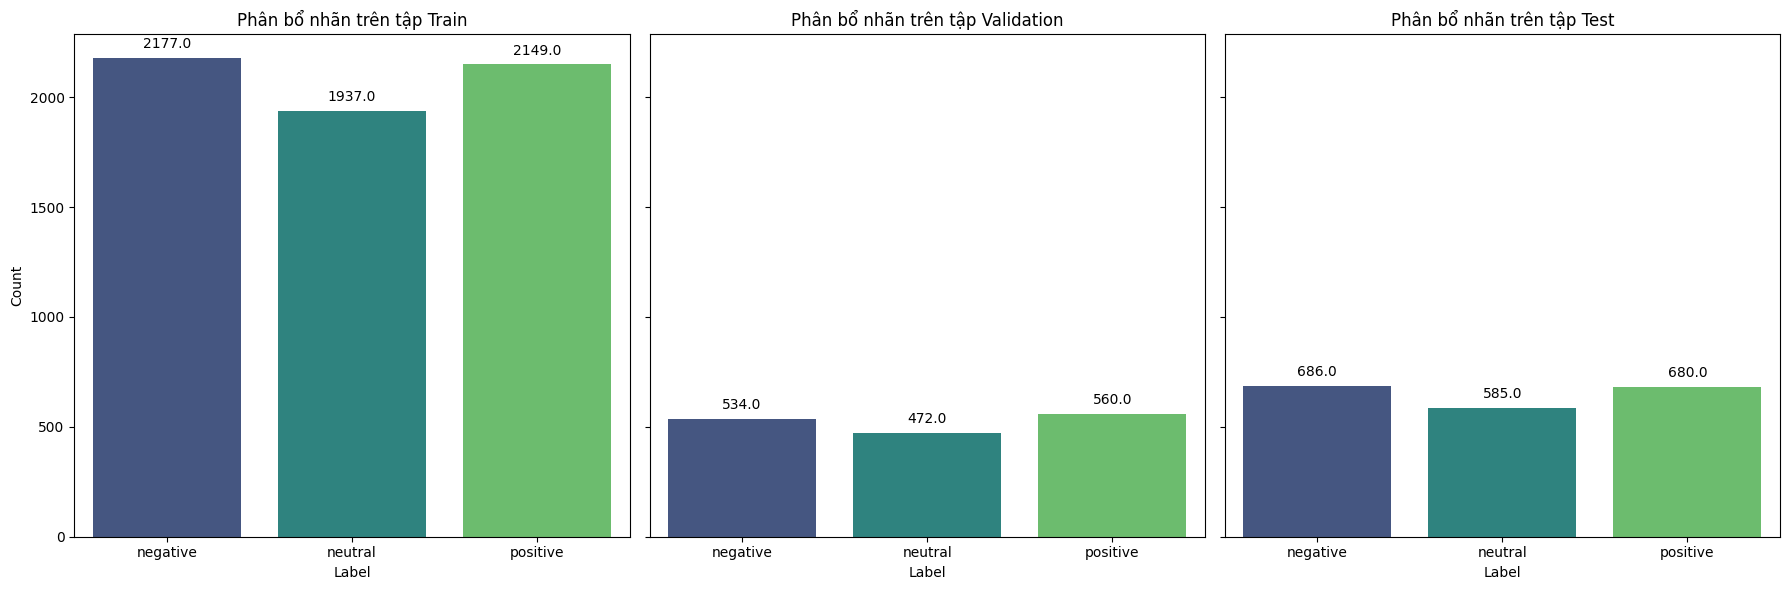

In [18]:
# Tạo DataFrame từ các tập dữ liệu
train_data_visualize = pd.DataFrame({'Label': train, 'Dataset': 'Train'})
val_data_visualize = pd.DataFrame({'Label': val, 'Dataset': 'Validation'})
test_data_visualize = pd.DataFrame({'Label': test, 'Dataset': 'Test'})

# Kết hợp cả ba DataFrame thành một để thuận tiện cho việc visualize
combined_data = pd.concat([train_data_visualize, val_data_visualize, test_data_visualize])

# Sử dụng seaborn để vẽ biểu đồ
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Biểu đồ cho tập train
sns.countplot(x='Label', data=train_data_visualize, palette='viridis', ax=axes[0], order=[0, 1, 2])
axes[0].set_title('Phân bổ nhãn trên tập Train')
axes[0].set_xlabel('Label')
axes[0].set_xticklabels(['negative', 'neutral', 'positive'])
axes[0].set_ylabel('Count')

# Thêm ô chú thích
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Biểu đồ cho tập validation
sns.countplot(x='Label', data=val_data_visualize, palette='viridis', ax=axes[1], order=[0, 1, 2])
axes[1].set_title('Phân bổ nhãn trên tập Validation')
axes[1].set_xlabel('Label')
axes[1].set_xticklabels(['negative', 'neutral', 'positive'])
axes[1].set_ylabel('Count')

# Thêm ô chú thích
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Biểu đồ cho tập test
sns.countplot(x='Label', data=test_data_visualize, palette='viridis', ax=axes[2], order=[0, 1, 2])
axes[2].set_title('Phân bổ nhãn trên tập Test')
axes[2].set_xlabel('Label')
axes[2].set_xticklabels(['negative', 'neutral', 'positive'])
axes[2].set_ylabel('Count')

# Thêm ô chú thích
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()



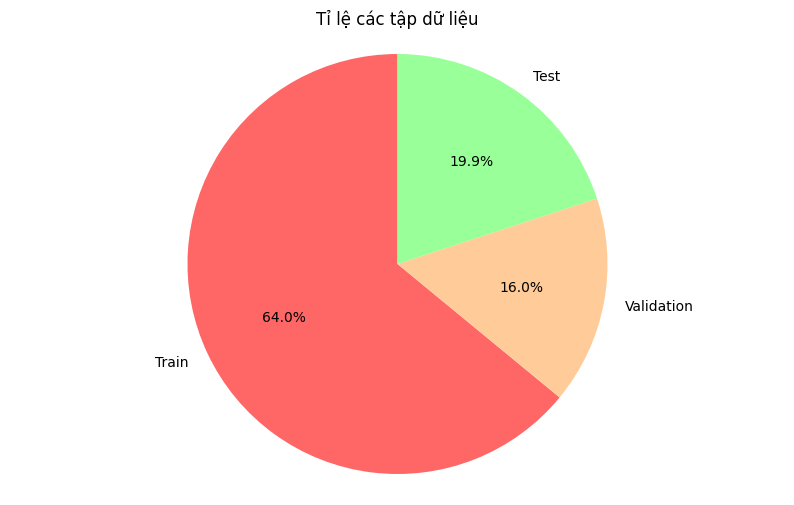

In [19]:
# Tạo DataFrame mới với thông tin về tập dữ liệu và số lượng câu
data_size = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Size': [len(train), len(val), len(test)]
})

# Vẽ biểu đồ tròn
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#ff6666', '#ffcc99', '#99ff99']
ax.pie(data_size['Size'], labels=data_size['Dataset'], autopct='%.1f%%', colors=colors, startangle=90)

# Thêm tiêu đề và chú thích
ax.set_title('Tỉ lệ các tập dữ liệu')
ax.axis('equal')  # Đảm bảo biểu đồ tròn

# Hiển thị biểu đồ
plt.show()


## Preprocessing

In [20]:
!pip install py_vncorenlp

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.6 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4306 sha256=07f989589a55dbf93bb1eef4d69977686e6b3b165a1c84199aab5b84a01de5a5
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


In [21]:
!mkdir -p vncorenlp

In [22]:
import py_vncorenlp
import re

In [23]:
py_vncorenlp.download_model(save_dir='/content/vncorenlp')
vncore = py_vncorenlp.VnCoreNLP(save_dir='/content/vncorenlp')

1. Chuẩn hóa câu (xóa đi các dấu cách thừa, kí tự không cần thiết)
2. Tách từ (sử dụng thư viện VnCoreNLP)
3. Lọc bỏ stopwords
4. Đưa về chữ thường

In [24]:
# xóa đi các dấu cách thừa, các từ không cần thiết
def normalize_text(text):
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',text)
    text = re.sub(r'\s+',' ',text).strip()
    return text


# tách từ bằng vncorenlp
def tokenize_text(text):
    return vncore.word_segment(text)

# lọc bỏ stopwords
stopwords = set(open('/content/drive/MyDrive/IE403/Dataset/Syn-VSFC/vietnamese-stopwords-dash.txt').read().splitlines())
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords]

# đưa về chữ thường
def to_lowercase(tokens):
    return [token.lower() for token in tokens]

In [25]:
def preprocess_text(text):
    text = normalize_text(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = to_lowercase(tokens)
    return tokens

In [26]:
data_train['sentence'] = data_train['sentence'].apply(preprocess_text)
data_test['sentence'] = data_test['sentence'].apply(preprocess_text)

In [27]:
# đưa cột 'sentence' về kiểu chuỗi
def convert_list_to_string(data):
  for i in range(len(data)):
    data['sentence'][i] = ' '.join(data['sentence'][i])
  return data

data_train = convert_list_to_string(data_train)
data_test = convert_list_to_string(data_test)


Streaming output truncated to the last 5000 lines.
<ipython-input-27-4145297b4fd1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = ' '.join(data['sentence'][i])
<ipython-input-27-4145297b4fd1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = ' '.join(data['sentence'][i])
<ipython-input-27-4145297b4fd1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentence'][i] = ' '.join(data['sent

## Vectorizing

tách dữ liệu ban đầu thành x và y

In [28]:
X_train = data_train['sentence']
y_train = data_train['sentiment']
X_test = data_test['sentence']
y_test = data_test['sentiment']

In [29]:
# chuyển dữ liệu thành danh sách các từ vựng
X_train = [sentence.split() for sentence in X_train]
X_test = [sentence.split() for sentence in X_test]

In [30]:
max_length = max([len(sentence) for sentence in X_train])

In [31]:
max_length

30

In [32]:
X_train

[['đội_ngũ',
  'bảo_trì',
  'quá',
  'thưa_thớt',
  'dẫn',
  'đến',
  'không',
  'đảm_bảo',
  'được',
  'chất_lượng',
  'sửa_chữa',
  'thiết_bị'],
 ['phương_pháp',
  'giảng_dạy',
  'phù_hợp',
  'với',
  'các',
  'đối_tượng',
  'sinh_viên',
  'khác',
  'nhau'],
 ['chương_trình',
  'học',
  'giúp',
  'tôi',
  'trở_thành',
  'một',
  'chuyên_gia',
  'trong',
  'lĩnh_vực',
  'của',
  'mình'],
 ['tôi',
  'nghĩ',
  'rằng',
  'chương_trình',
  'đào_tạo',
  'có_thể',
  'có',
  'thêm',
  'các',
  'môn_học',
  'về',
  'lịch_sử',
  'và',
  'văn_hoá',
  'để',
  'sinh_viên',
  'hiểu',
  'rõ',
  'hơn',
  'về',
  'đất_nước',
  'và',
  'con_người',
  'việt_nam'],
 ['chị', 'ấy', 'luôn', 'tỉ_mỉ', 'trong', 'công_việc'],
 ['tôi',
  'không',
  'thích',
  'giảng_viên',
  'này',
  'vì',
  'anh',
  'ta',
  'không',
  'có',
  'kỷ_luật'],
 ['giảng_viên',
  'này',
  'quá',
  'yêu_cầu',
  'với',
  'sinh_viên',
  'khiến',
  'họ',
  'không_thể',
  'tự_do',
  'học_tập'],
 ['anh',
  'bạn',
  'là',
  'người',
  'luôn'

vector hóa câu văn bằng mô hình Word2Vec

In [33]:
from gensim.models import Word2Vec

# tạo mô hình Word2Vec từ X_train
model = Word2Vec(X_train, vector_size=30, window=5, min_count=1, workers=8, sg=1)

# Vector hóa từng câu trong dữ liệu train
X_train_vec = []
for sentence in X_train:
    vec = np.zeros(30)
    for word in sentence:
        try:
            vec += model.wv[word]
        except KeyError:
            # nếu có một từ không có trong từ điển của mô hình, bỏ qua nó
            pass
    vec /= len(sentence)
    X_train_vec.append(vec)

# Vector hóa từng câu trong dữ liệu test
X_test_vec = []
for sentence in X_test:
    vec = np.zeros(30)
    for word in sentence:
        try:
            vec += model.wv[word]
        except KeyError:
            # nếu có một từ không có trong từ điển của mô hình, bỏ qua nó
            pass
    vec /= len(sentence)
    X_test_vec.append(vec)


In [34]:
X_train_vec[0]

array([-1.04845944e-01,  4.29880262e-05,  5.00677772e-01, -7.82863088e-02,
        3.03926061e-01,  4.69128914e-02,  1.46991221e-01,  1.91152156e-01,
       -3.92404639e-01,  5.45340443e-03,  5.16490822e-01,  3.73101852e-02,
        7.92470366e-02, -7.83098138e-01, -2.99728852e-02, -4.65348806e-01,
        2.64565862e-02,  3.89020023e-01, -7.15574788e-02,  9.34467157e-02,
       -2.47615575e-01, -3.12159051e-01,  6.25999246e-02,  5.73489299e-01,
        2.97166126e-01,  4.32106101e-01,  2.92057754e-01,  2.71816658e-01,
       -3.54303386e-02, -3.97028053e-01])

## Training

### SVM

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, make_scorer

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}

scoring = {
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring=scoring, refit='f1')
grid_search.fit(X_train_vec, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             refit='f1',
             scoring={'f1': make_scorer(f1_score, average=macro),
                      'precision': make_scorer(precision_score, average=macro),
                      'recall': make_scorer(recall_score, average=macro)})

In [36]:
svm_best_params = grid_search.best_params_
svm_best_model = grid_search.best_estimator_

In [37]:
svm_best_params

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [38]:
svm_best_model

SVC(C=10, gamma=1)

In [39]:
# thực hiện dự đoán
y_pred = svm_best_model.predict(X_test_vec)

In [40]:
svm_report = classification_report(y_test, y_pred)
print(svm_report)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       686
           1       0.69      0.61      0.65       585
           2       0.72      0.77      0.75       680

    accuracy                           0.78      1951
   macro avg       0.77      0.77      0.77      1951
weighted avg       0.78      0.78      0.78      1951



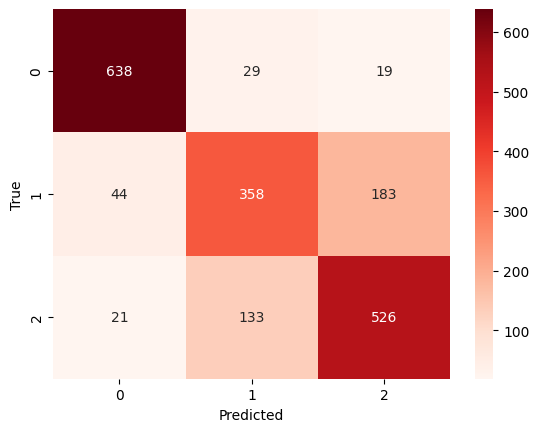

In [41]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [42]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7801127626858022


Lưu model

In [43]:
# import joblib
# joblib.dump(svm_best_model, '/content/drive/MyDrive/IE403/Model/Syn_svm_model.joblib')

### CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

chuyển dữ liệu từ numpy array sang tensor

In [ ]:
X_train_tensor = torch.tensor(X_train_vec, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

<ipython-input-30-6df413c9476c>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  X_train_tensor = torch.tensor(X_train_vec, dtype=torch.float32)


In [ ]:
X_test_tensor = torch.tensor(X_test_vec, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
X_train_tensor

tensor([[-0.2318, -0.1293,  0.5622,  ...,  0.2523,  0.0600, -0.2259],
        [-0.1790, -0.4086,  0.5018,  ...,  0.4451,  0.1204, -0.2868],
        [-0.2607, -0.5851,  0.5308,  ...,  0.4643,  0.4192, -0.4572],
        ...,
        [-0.1519, -0.5562,  0.4385,  ...,  0.4087,  0.2924, -0.5887],
        [-0.3235, -0.4051,  0.6381,  ...,  0.3875,  0.3842, -0.1618],
        [-0.2954, -0.3887,  0.5893,  ...,  0.3924,  0.2696, -0.4340]])

In [ ]:
y_train_tensor

tensor([0, 1, 2,  ..., 2, 1, 0])

In [ ]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([7829, 30])
torch.Size([7829])


huấn luyện bằng CNN

In [ ]:
# Thiết bị huấn luyện (GPU nếu có, CPU nếu không)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Đảm bảo dữ liệu đã được chuyển đổi thành tensor và trên đúng thiết bị
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.long().to(device)  # Chuyển đổi y_train_tensor thành kiểu Long (int64)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.long().to(device)  # Chuyển đổi y_test_tensor thành kiểu Long (int64)

# Tạo TensorDataset và DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Định nghĩa mô hình CNN
class CNN(nn.Module):
    def __init__(self, input_dim, num_filters, filter_sizes, output_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=3, padding=1)
        self.fc = nn.Linear(num_filters * 2 * 7, output_dim)  # Điều chỉnh kích thước đầu vào cho fully connected layer

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

# Khởi tạo mô hình, hàm loss và optimizer
input_dim = X_train_tensor.size(1)  # Số lượng đặc trưng
num_filters = 100
filter_sizes = [3, 4, 5]
output_dim = 3  # Số lượng lớp

model = CNN(input_dim, num_filters, filter_sizes, output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Huấn luyện và đánh giá mô hình
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    total_samples = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Chuyển dữ liệu lên device
        batch_X = batch_X.unsqueeze(1)  # Thêm chiều cho kênh đầu vào (batch_size, channels, features)

        optimizer.zero_grad()  # Đặt gradient về 0 trước mỗi lần cập nhật
        outputs = model(batch_X)  # Lan truyền xuôi
        loss = criterion(outputs, batch_y)  # Tính toán mất mát
        loss.backward()  # Lan truyền ngược
        optimizer.step()  # Cập nhật trọng số

        train_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)  # Lấy chỉ số của lớp có xác suất cao nhất
        train_correct += (predicted == batch_y).sum().item()
        total_samples += batch_y.size(0)

    train_acc = train_correct / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")


Epoch [1/100], Train Loss: 6472.5113, Train Acc: 0.6111
Epoch [2/100], Train Loss: 5267.0600, Train Acc: 0.6749
Epoch [3/100], Train Loss: 5075.5571, Train Acc: 0.6857
Epoch [4/100], Train Loss: 4978.3425, Train Acc: 0.6913
Epoch [5/100], Train Loss: 4827.6881, Train Acc: 0.7061
Epoch [6/100], Train Loss: 4783.2172, Train Acc: 0.7089
Epoch [7/100], Train Loss: 4665.3813, Train Acc: 0.7184
Epoch [8/100], Train Loss: 4626.5130, Train Acc: 0.7246
Epoch [9/100], Train Loss: 4605.4398, Train Acc: 0.7195
Epoch [10/100], Train Loss: 4524.5153, Train Acc: 0.7305
Epoch [11/100], Train Loss: 4523.7846, Train Acc: 0.7300
Epoch [12/100], Train Loss: 4462.3370, Train Acc: 0.7311
Epoch [13/100], Train Loss: 4459.2643, Train Acc: 0.7302
Epoch [14/100], Train Loss: 4373.1465, Train Acc: 0.7336
Epoch [15/100], Train Loss: 4372.6331, Train Acc: 0.7378
Epoch [16/100], Train Loss: 4351.8842, Train Acc: 0.7399
Epoch [17/100], Train Loss: 4368.5691, Train Acc: 0.7361
Epoch [18/100], Train Loss: 4321.0353, T

In [ ]:
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([1951, 30])
torch.Size([1951])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

              precision    recall  f1-score   support

     class 0       0.88      0.94      0.91       686
     class 1       0.71      0.35      0.47       585
     class 2       0.63      0.86      0.72       680

    accuracy                           0.74      1951
   macro avg       0.74      0.72      0.70      1951
weighted avg       0.74      0.74      0.71      1951



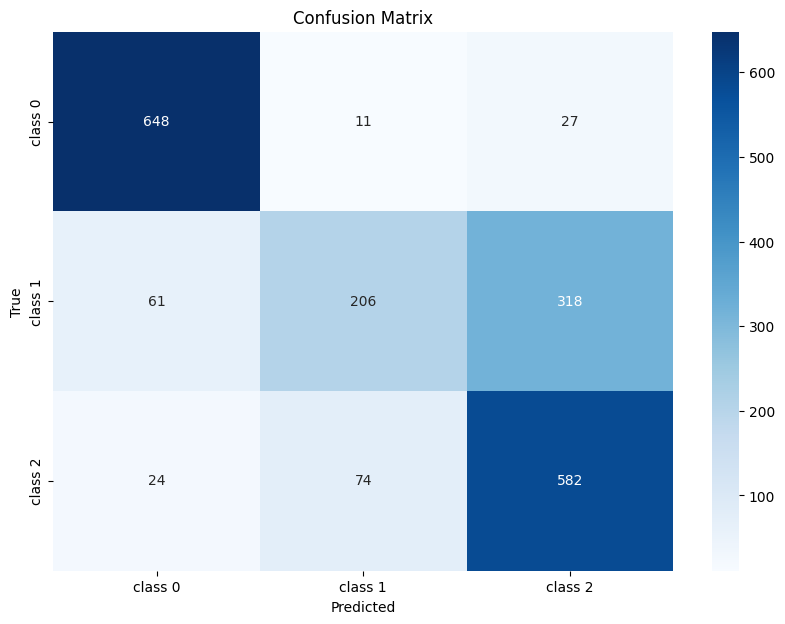

In [ ]:
# Dự đoán trên bộ dữ liệu test
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.unsqueeze(1)  # Thêm chiều cho kênh đầu vào nếu cần

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Báo cáo classification report
report = classification_report(y_true, y_pred, target_names=['class 0', 'class 1', 'class 2'])
print(report)

# Vẽ confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['class 0', 'class 1', 'class 2'], yticklabels=['class 0', 'class 1', 'class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

NameError: name 'metrics' is not defined

Lưu model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/IE403/Model/Syn_cnn_model.pth')

### PhoBert

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import TrainingArguments, Trainer
from sklearn import metrics

phobert = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base-v2", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [ ]:
train_sentences = [' '.join(i) for i in X_train]
val_sentences = [' '.join(i) for i in X_val]
test_sentences = [' '.join(i) for i in X_test]

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=30)
val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=30)
test_encodings = tokenizer(test_sentences, truncation=True, padding=True, max_length=30)

In [ ]:
y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)

In [ ]:
train_dataset = BuildDataset(train_encodings, y_train)
val_dataset = BuildDataset(val_encodings, y_val)
test_dataset = BuildDataset(test_encodings, y_test)

tạo thêm tập val từ tập train

In [ ]:
# train_data = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_data = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_data = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Training parameters
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/IE403/Model/phobert',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=phobert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Step,Training Loss
500,0.661600
1000,0.487600
1500,0.418800
2000,0.364100


TrainOutput(global_step=2349, training_loss=0.4555200842300746, metrics={'train_runtime': 10218.4729, 'train_samples_per_second': 1.839, 'train_steps_per_second': 0.23, 'total_flos': 289666289395980.0, 'train_loss': 0.4555200842300746, 'epoch': 3.0})

dự đoán trên tập test

In [ ]:
predictions = trainer.predict(test_dataset)

In [ ]:
# y_pred_tensor = torch.argmax(torch.Tensor(predictions.predictions), dim=-1)

In [ ]:
y_pred_array = np.argmax(predictions.predictions, axis=-1)
y_true = np.array(y_test)

In [ ]:
y_pred_array

array([0, 0, 0, ..., 0, 1, 2])

In [ ]:
y_true

array([0, 0, 0, ..., 0, 2, 2])

              precision    recall  f1-score   support

     class 0       0.98      0.98      0.98       686
     class 1       0.73      0.79      0.76       585
     class 2       0.82      0.77      0.80       680

    accuracy                           0.85      1951
   macro avg       0.85      0.85      0.85      1951
weighted avg       0.85      0.85      0.85      1951



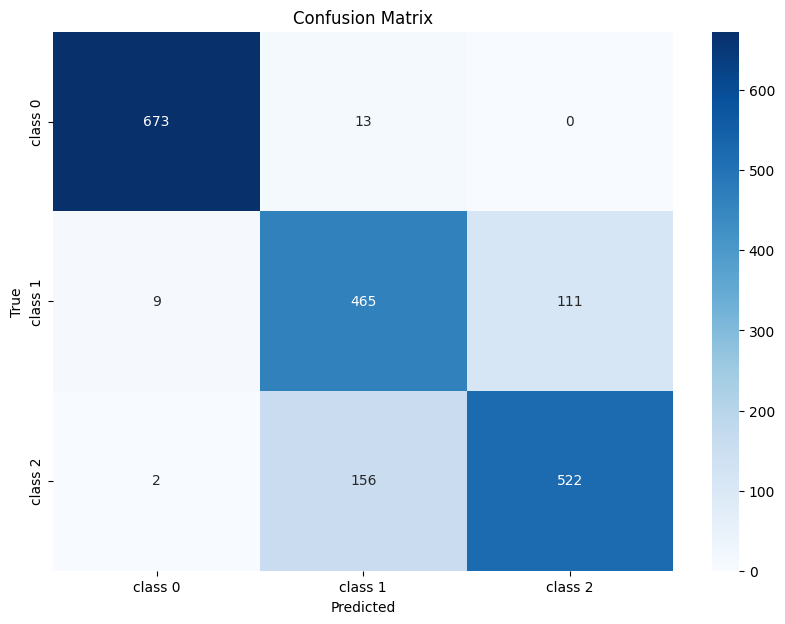

In [ ]:
# prompt: hãy tạo classifycation report và confusion matrix của kết quả dự đoán

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Tạo classification report
report = classification_report(y_true, y_pred_array, target_names=['class 0', 'class 1', 'class 2'])
print(report)

# Vẽ confusion matrix
cm = confusion_matrix(y_true, y_pred_array)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['class 0', 'class 1', 'class 2'], yticklabels=['class 0', 'class 1', 'class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Lưu model

In [ ]:
trainer.save_model('/content/drive/MyDrive/IE403/Model/phobert/syn_phobert.pth')

### VisoBert


khởi tạo model

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import TrainingArguments, Trainer
from sklearn import metrics

visobert = AutoModelForSequenceClassification.from_pretrained("uitnlp/visobert", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("uitnlp/visobert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/390M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/471k [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

train_sentences = [' '.join(i) for i in X_train]
val_sentences = [' '.join(i) for i in X_val]
test_sentences = [' '.join(i) for i in X_test]

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=30)
val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=30)
test_encodings = tokenizer(test_sentences, truncation=True, padding=True, max_length=30)

y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)

train_dataset = BuildDataset(train_encodings, y_train)
val_dataset = BuildDataset(val_encodings, y_val)
test_dataset = BuildDataset(test_encodings, y_test)

In [ ]:
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/IE403/Model/visobert',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=visobert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(axis=1) == p.label_ids).mean()},
)

trainer.train()

Step,Training Loss
500,0.664700
1000,0.495300
1500,0.400900
2000,0.310800


TrainOutput(global_step=2349, training_loss=0.4403889649165037, metrics={'train_runtime': 300.7835, 'train_samples_per_second': 62.467, 'train_steps_per_second': 7.81, 'total_flos': 289666289395980.0, 'train_loss': 0.4403889649165037, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(test_dataset)

              precision    recall  f1-score   support

     class 0       0.98      0.97      0.97       686
     class 1       0.75      0.73      0.74       585
     class 2       0.79      0.82      0.81       680

    accuracy                           0.85      1951
   macro avg       0.84      0.84      0.84      1951
weighted avg       0.85      0.85      0.85      1951



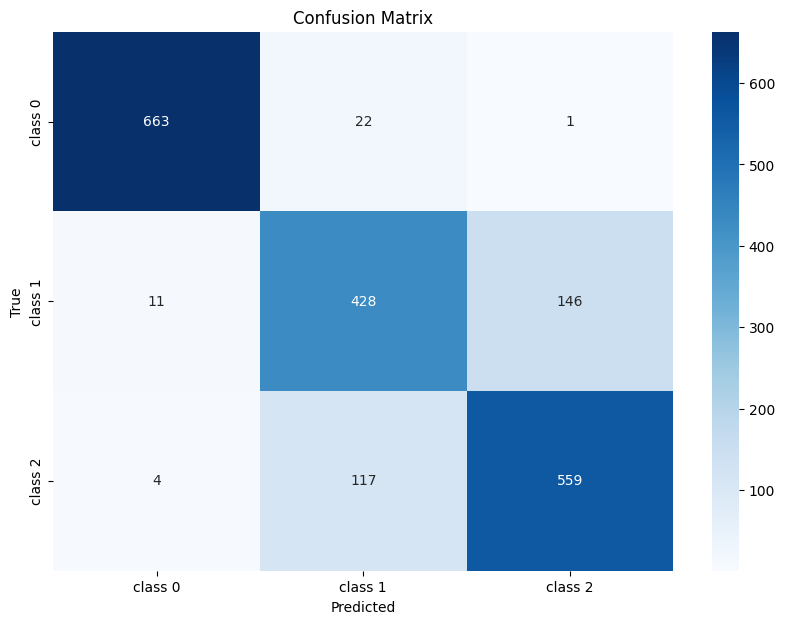

In [ ]:
y_pred_array = np.argmax(predictions.predictions, axis=-1)
y_true = np.array(y_test)

# prompt: hãy tạo classifycation report và confusion matrix của kết quả dự đoán

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Tạo classification report
report = classification_report(y_true, y_pred_array, target_names=['class 0', 'class 1', 'class 2'])
print(report)

# Vẽ confusion matrix
cm = confusion_matrix(y_true, y_pred_array)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['class 0', 'class 1', 'class 2'], yticklabels=['class 0', 'class 1', 'class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Lưu model

In [ ]:
trainer.save_model('/content/drive/MyDrive/IE403/Model/visobert/syn_visobert.pth')

### CafeBert


khởi tạo model

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import TrainingArguments, Trainer
from sklearn import metrics

cafebert = AutoModelForSequenceClassification.from_pretrained("uitnlp/CafeBERT", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("uitnlp/CafeBERT")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/CafeBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# train_sentences = [' '.join(i) for i in X_train]
# val_sentences = [' '.join(i) for i in X_val]
# test_sentences = [' '.join(i) for i in X_test]

# class BuildDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)

# train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=30)
# val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=30)
# test_encodings = tokenizer(test_sentences, truncation=True, padding=True, max_length=30)

# y_train = list(y_train)
# y_val = list(y_val)
# y_test = list(y_test)

# train_dataset = BuildDataset(train_encodings, y_train)
# val_dataset = BuildDataset(val_encodings, y_val)
# test_dataset = BuildDataset(test_encodings, y_test)

In [ ]:
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/IE403/Model/cafebert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=cafebert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Step,Training Loss
500,0.814100
1000,0.604400


TrainOutput(global_step=1176, training_loss=0.6701816052806621, metrics={'train_runtime': 942.548, 'train_samples_per_second': 19.934, 'train_steps_per_second': 1.248, 'total_flos': 1025983450099980.0, 'train_loss': 0.6701816052806621, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(test_dataset)

              precision    recall  f1-score   support

     class 0       0.94      0.94      0.94       686
     class 1       0.70      0.61      0.65       585
     class 2       0.73      0.80      0.76       680

    accuracy                           0.79      1951
   macro avg       0.79      0.78      0.78      1951
weighted avg       0.79      0.79      0.79      1951



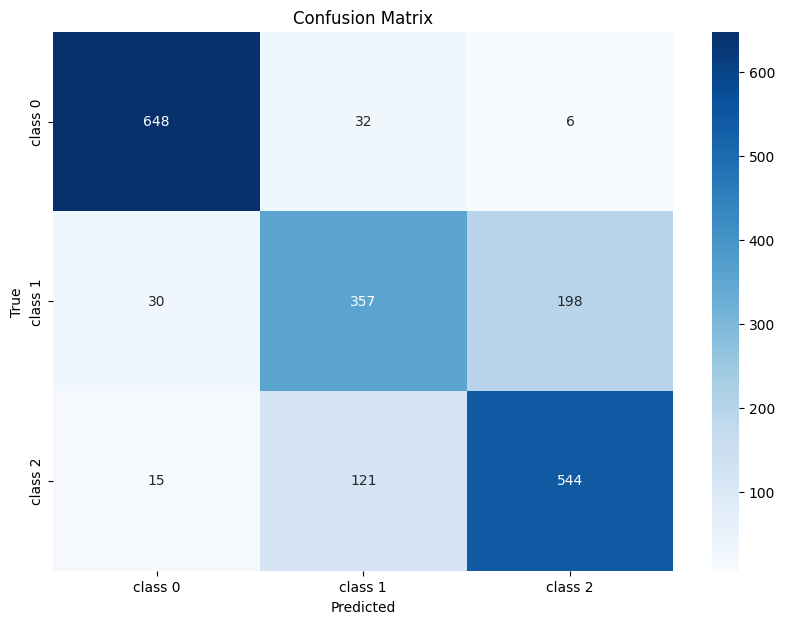

In [ ]:
y_pred_array = np.argmax(predictions.predictions, axis=-1)
y_true = np.array(y_test)

# prompt: hãy tạo classifycation report và confusion matrix của kết quả dự đoán

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Tạo classification report
report = classification_report(y_true, y_pred_array, target_names=['class 0', 'class 1', 'class 2'])
print(report)

# Vẽ confusion matrix
cm = confusion_matrix(y_true, y_pred_array)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['class 0', 'class 1', 'class 2'], yticklabels=['class 0', 'class 1', 'class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Lưu model

In [ ]:
trainer.save_model('/content/drive/MyDrive/IE403/Model/cafebert/syn_cafebert.pth')